# Binary Classification

* I start with a simply binary classification problem: pro-refugees tweets vs. not-pro-refugees tweets. In order to do so I used various **classification models**. 

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from stop_words import get_stop_words

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix


from sklearn.model_selection import learning_curve

#LIME
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer




In [2]:
# stop_words = get_stop_words('english')
# stop_words.extend(['', 're', 'rt', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's', 'b',
#                   'aren', 'can', 'couldn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 'shan', 'shouldn', 
#                    'wasn', 'weren', 'won', 'wouldn'])

In [3]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [4]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

## Import dataset and data preparation

In [5]:
df = pd.read_csv('../../data_collection/data/cleaned_tweet.csv')
df = df.drop(columns=['Unnamed: 0'])

C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


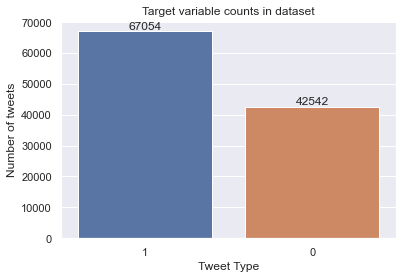

In [6]:
unique= df["tweet_label"].unique()
freq = df["tweet_label"].value_counts()
sns.set(font_scale = 1)

ax = sns.countplot(df["tweet_label"], 
                   order = df["tweet_label"].value_counts().index)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

# adding the text labels
rects = ax.patches
for rect, label in zip(rects, freq):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [7]:
#df = df.dropna()

In [8]:
max_len = np.max(df['text_len'])
max_len

40

In [9]:
df.sort_values(by=["text_len"], ascending=False)

,User,verified,Date_Created,Follows_Count,Friends_Count,Retweet_Count,Language,Date_Tweet,Number_of_Likes,Source_of_Tweet,...,Hashtags,Conversation_Id,In_reply_To,Coordinates,Place,tweet_label,text_clean,Tweet_tokenized,tokenized_bigram,text_len
3931,KlaMarx,False,2011-10-24 10:28:54+00:00,298,527,0,it,2021-05-11 06:43:50+00:00,0,Twitter Web App,...,"['FreePalestine', 'Restiamoumani']",1392007525508292613,NaN,NaN,NaN,1,basta basta basta basta basta basta basta bast...,"['basta', 'basta', 'basta', 'basta', 'basta', ...","[('basta', 'basta'), ('basta', 'basta'), ('bas...",40
39392,EugenioCardi,False,2016-01-03 11:16:30+00:00,19899,4993,7,it,2019-01-26 18:31:28+00:00,15,Twitter for Android,...,"['restiamoumani', 'SeaWatch3', 'razzismo', 'Sa...",1089229349440622592,NaN,"Coordinates(longitude=12.2344266, latitude=41....","Place(fullName='Rome, Lazio', name='Rome', typ...",1,minori conv ny 20 11 89 conv cons eu 25 01 96 ...,"['minori', 'conv', 'ny', '20', '11', '89', 'co...","[('minori', 'conv'), ('conv', 'ny'), ('ny', '2...",35
77535,18Girin,False,2019-06-12 18:33:07+00:00,736,828,2,it,2019-11-24 09:30:31+00:00,1,Twitter for Android,...,['portichiusi'],1198520354198708225,https://twitter.com/matteosalvinimi,NaN,NaN,0,2018 novembre 23 sbarchi 523 2019 novembre 23 ...,"['2018', 'novembre', '23', 'sbarchi', '523', '...","[('2018', 'novembre'), ('novembre', '23'), ('2...",35
42333,FraRicci_,False,2011-09-18 14:31:44+00:00,162,517,14,it,2019-01-19 14:23:32+00:00,28,Twitter Web App,...,"['naufragio', 'apriteiporti', 'RestiamoUmani']",1086630240863092738,NaN,NaN,NaN,1,91 92 93 94 95 96 97 98 99 100 101 102 103 104...,"['91', '92', '93', '94', '95', '96', '97', '98...","[('91', '92'), ('92', '93'), ('93', '94'), ('9...",35
88369,DavideIanny,False,2012-02-08 15:23:02+00:00,27,50,0,it,2019-06-29 09:17:24+00:00,0,Twitter for Android,...,"['portichiusi', 'CarolaRackete']",1144832184630558720,https://twitter.com/DavideIanny,NaN,NaN,0,risultati politiche 2018 cd 37 m5s 32 68 cs 22...,"['risultati', 'politiche', '2018', 'cd', '37',...","[('risultati', 'politiche'), ('politiche', '20...",33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49739,puravidaita,False,2013-02-25 15:29:28+00:00,1320,1393,0,it,2018-09-12 09:15:49+00:00,1,Twitter for Android,...,"['restiamoumani', 'cheschifo']",1039277005160828929,https://twitter.com/alessandrazinit,NaN,NaN,1,NaN,[''],[],0
78823,Capobianco2005C,False,2018-09-01 15:59:43+00:00,502,90,0,it,2019-09-29 17:12:27+00:00,0,Twitter Web App,...,"['realtà', 'portichiusi']",1178356881305284608,NaN,NaN,NaN,0,NaN,[''],[],0
78827,Federic45746096,False,2019-09-15 13:39:52+00:00,161,111,0,it,2019-09-29 16:26:16+00:00,1,Twitter for Android,...,"['orgoglioItaliano', 'portichiusi', 'primaglii...",1178313063335903235,https://twitter.com/matteosalvinimi,NaN,NaN,0,NaN,[''],[],0
107678,carmentpf,False,2013-07-28 04:27:11+00:00,12425,6465,3,it,2019-01-03 20:36:49+00:00,10,Twitter Web Client,...,"['RT', 'portichiusi']",1080925974156509184,NaN,NaN,NaN,0,NaN,[''],[],0


## Dataset split

In [10]:
data = 'Tweet_tokenized'
target = 'tweet_label'
X_train, X_test, y_train, y_test = train_test_split(df[data], df[target], test_size=0.3, random_state=42)

In [11]:
print("x_train ->", len(X_train), "record")
print("x_test  ->", len(X_test), "record")
print("y_train ->", len(y_train), "record")
print("y_test  ->", len(y_test), "record")

x_train -> 76717 record
x_test  -> 32879 record
y_train -> 76717 record
y_test  -> 32879 record


In [12]:
y_train.value_counts()

1    46760
0    29957
Name: tweet_label, dtype: int64

## Class balancing

In [13]:
#oversampling 
ros = RandomOverSampler(sampling_strategy = 0.8)
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['Tweet_tokenized', 'tweet_label'])
X_train = train_os['Tweet_tokenized'].values
y_train = train_os['tweet_label'].values

In [14]:
#undersampling 
rus = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = rus.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['Tweet_tokenized', 'tweet_label'])
X_train = train_os['Tweet_tokenized'].values
y_train = train_os['tweet_label'].values

In [15]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 37408],
       [    1, 37408]], dtype=int64)

C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


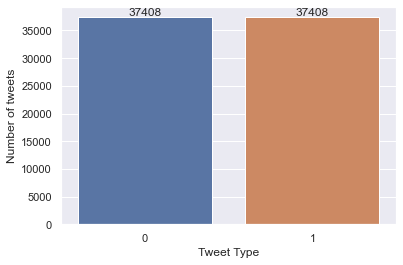

In [16]:
sns.set(font_scale = 1)

ax = sns.barplot(unique, counts)
#plt.title("Target variable counts in balanced dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

## Tokenization

In [17]:
idx = 1

vect = CountVectorizer(min_df = 5, ngram_range=(1,3))   # min_df: minimum number of words in a sentence
X_train_tok = vect.fit_transform(X_train)
X_test_tok =vect.transform(X_test)

In [18]:
len(vect.vocabulary_)

28841

In [19]:
vect.vocabulary_

{'parliamoci': 17919,
 'chiaro': 4749,
 'sig': 24160,
 'ministro': 15543,
 'pensa': 18309,
 'veramente': 27817,
 'poter': 19565,
 'continuare': 5974,
 'gestire': 10940,
 'questione': 21028,
 'emergenze': 8738,
 'modo': 15696,
 'semplicemente': 23720,
 'parliamoci chiaro': 17920,
 'sig ministro': 24161,
 'poter continuare': 19567,
 'davvero': 6905,
 'convinto': 6092,
 'accordo': 790,
 'merito': 15140,
 'ora': 17275,
 'ripensamenti': 22082,
 'voto': 28651,
 'causa': 4459,
 'fatti': 9833,
 'provocati': 20486,
 'quegli': 20961,
 'volta': 28531,
 'capito': 4196,
 'proprio': 20339,
 'niente': 16491,
 'ancor': 1562,
 'proprio niente': 20355,
 'vedo': 27689,
 'popolo': 19167,
 'ribella': 21652,
 'salvini': 22749,
 'porti': 19281,
 'violati': 28184,
 'difesa': 7568,
 'cittadini': 5042,
 'dietro': 7531,
 'tastiera': 25976,
 'vigliacchi': 28113,
 'navi': 16218,
 'ong': 17126,
 '400': 378,
 'clandestini': 5115,
 'lampedusa': 13569,
 'fateci': 9800,
 'scendere': 23311,
 'salvini porti': 22805,
 'di

In [20]:
vect.get_feature_names()

C:\Users\Martina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '00 20',
 '00 piazza',
 '000',
 '000 000',
 '000 clandestini',
 '000 euro',
 '000 immigrati',
 '000 italiani',
 '000 migranti',
 '000 morti',
 '000 persone',
 '01',
 '01 2019',
 '02',
 '02 03',
 '02 03 2019',
 '03',
 '03 2019',
 '03 2019 diretta',
 '04',
 '04 2011',
 '05',
 '06',
 '07',
 '08',
 '09',
 '09 wu',
 '09 wu ming',
 '10',
 '10 000',
 '10 10',
 '10 100',
 '10 100 1000',
 '10 15',
 '10 30',
 '10 anni',
 '10 anni fa',
 '10 euro',
 '10 gg',
 '10 giorni',
 '10 giorno',
 '10 giorno dopo',
 '10 metri',
 '10 migranti',
 '10 mila',
 '10 milioni',
 '10 minuti',
 '10 persone',
 '10 volte',
 '10 volte piu',
 '100',
 '100 000',
 '100 1000',
 '100 bambini',
 '100 esseri',
 '100 esseri umani',
 '100 giustizia',
 '100 giustizia indagini',
 '100 kg',
 '100 migranti',
 '100 morti',
 '100 persone',
 '100 volte',
 '1000',
 '100mila',
 '101',
 '104',
 '104 persone',
 '107',
 '108',
 '10mila',
 '11',
 '11 00',
 '11 11',
 '11 anni',
 '11 bambini',
 '11 bambini donne',
 '11 giorni',
 '11 mes

In [21]:
X_train_tok[idx,:]

<1x28841 sparse matrix of type '<class 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [22]:
print(X_train_tok[idx,:])

  (0, 6905)	1
  (0, 6092)	1
  (0, 790)	1
  (0, 15140)	1
  (0, 17275)	1
  (0, 22082)	1
  (0, 28651)	1
  (0, 4459)	1
  (0, 9833)	1
  (0, 20486)	1
  (0, 20961)	1
  (0, 28531)	1
  (0, 4196)	1
  (0, 20339)	1
  (0, 16491)	1
  (0, 1562)	1
  (0, 20355)	1


In [23]:
vect.inverse_transform(X_train_tok[idx,:])

[array(['davvero', 'convinto', 'accordo', 'merito', 'ora', 'ripensamenti',
        'voto', 'causa', 'fatti', 'provocati', 'quegli', 'volta', 'capito',
        'proprio', 'niente', 'ancor', 'proprio niente'], dtype='<U41')]

In [24]:
for feat,freq in zip(vect.inverse_transform(X_train_tok[idx,:])[0],X_train_tok[idx,:].data):
    print(feat,freq)

davvero 1
convinto 1
accordo 1
merito 1
ora 1
ripensamenti 1
voto 1
causa 1
fatti 1
provocati 1
quegli 1
volta 1
capito 1
proprio 1
niente 1
ancor 1
proprio niente 1


## Feature selection
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator
* SelectKBest removes all but takes the K highest scoring features

In [25]:
bin_sel = SelectKBest(chi2, k = 5000).fit(X_train_tok,y_train) 
X_train_sel_bin = bin_sel.transform(X_train_tok)
X_test_sel_bin = bin_sel.transform(X_test_tok)

In [26]:
bin_sel.get_support()

array([False, False,  True, ..., False, False, False])

In [27]:
X_train_sel_bin

<74816x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 388388 stored elements in Compressed Sparse Row format>

In [28]:
X_train_sel_bin[idx,:]

<1x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [29]:
print(X_train_sel_bin[idx,:])

  (0, 115)	1
  (0, 680)	1
  (0, 1148)	1
  (0, 1594)	1
  (0, 2752)	1
  (0, 2911)	1
  (0, 3442)	1
  (0, 3535)	1
  (0, 4942)	1
  (0, 4961)	1


In [30]:
print(vect.inverse_transform(bin_sel.inverse_transform(X_train_sel_bin[idx,:])))

[array(['accordo', 'capito', 'davvero', 'fatti', 'niente', 'ora',
       'proprio', 'quegli', 'volta', 'voto'], dtype='<U41')]


## Weigthing
Then we apply TF-IDF transformation to associate weights to the different words based on their frequency (rarer words will be given more importance).



In [31]:
tf_transformer_bin = TfidfTransformer(use_idf=True).fit(X_train_sel_bin)
X_train_tf_bin = tf_transformer_bin.transform(X_train_sel_bin)
X_test_tf_bin = tf_transformer_bin.transform(X_test_sel_bin)

In [32]:
print(X_train_tf_bin[idx,:])

  (0, 4961)	0.3425200172919464
  (0, 4942)	0.29027588740177385
  (0, 3535)	0.42834157926385036
  (0, 3442)	0.2771187758706891
  (0, 2911)	0.24054131356807554
  (0, 2752)	0.2935849230963593
  (0, 1594)	0.32010980056709676
  (0, 1148)	0.3032039155732328
  (0, 680)	0.31417891324200425
  (0, 115)	0.3177815342567833


In [33]:
for feat,weight,freq in zip(vect.inverse_transform(bin_sel.inverse_transform(X_train_tf_bin[idx,:]))[0],X_train_tf_bin[idx,:].data,X_train_sel_bin[idx,:].data):
    print(feat,weight,freq)
    

accordo 0.3425200172919464 1
capito 0.29027588740177385 1
davvero 0.42834157926385036 1
fatti 0.2771187758706891 1
niente 0.24054131356807554 1
ora 0.2935849230963593 1
proprio 0.32010980056709676 1
quegli 0.3032039155732328 1
volta 0.31417891324200425 1
voto 0.3177815342567833 1


## Naive Bayes
Without hyperparameter tuning because there aren't parameter to tune. 

In [34]:
bin_nb_clf = MultinomialNB(alpha= 0.5)
bin_nb_clf.fit(X_train_tf_bin, y_train)
bin_nb_pred = bin_nb_clf.predict(X_test_tf_bin)

In [35]:
print('Classification report:')
print(classification_report(y_test, bin_nb_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70     12585
           1       0.85      0.70      0.77     20294

    accuracy                           0.74     32879
   macro avg       0.74      0.75      0.73     32879
weighted avg       0.76      0.74      0.74     32879



In [36]:
bin_nb_scores = cross_val_score(bin_nb_clf, X_train_tf_bin, y_train, cv=10)
cv_results_nb = cross_validate(bin_nb_clf, X_train_tf_bin, y_train, cv=10)

In [37]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (bin_nb_scores.mean(), bin_nb_scores.std()))

0.77 accuracy with a standard deviation of 0.01


In [38]:
cv_results_nb['test_score']

array([0.77225341, 0.76663994, 0.77118418, 0.77252072, 0.76436782,
       0.75581395, 0.77756984, 0.78812993, 0.78051063, 0.77556476])

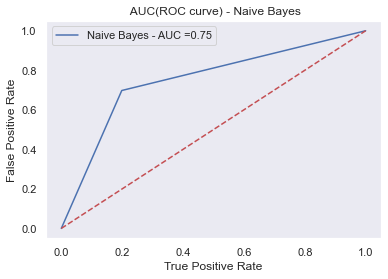

In [39]:
plot_roc_curve(y_test, bin_nb_pred, 'Naive Bayes')

## Linear SVC

In [40]:
bin_svm_clf = LinearSVC().fit(X_train_tf_bin, y_train)
bin_svm_pred = bin_svm_clf.predict(X_test_tf_bin)

In [41]:
print('Classification report:')
print(classification_report(y_test, bin_svm_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     12585
           1       0.82      0.79      0.81     20294

    accuracy                           0.77     32879
   macro avg       0.75      0.76      0.76     32879
weighted avg       0.77      0.77      0.77     32879



In [42]:
bin_svm_scores = cross_val_score(bin_svm_clf, X_train_tf_bin, y_train, cv=5)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_svm_scores.mean(), bin_svm_scores.std()))


 
0.78 accuracy with a standard deviation of 0.01


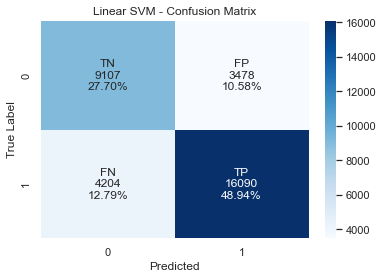

In [43]:
bin_svm_cm = confusion_matrix(y_test, bin_svm_pred)
make_confusion_matrix(bin_svm_cm, 'Linear SVM - Confusion Matrix')

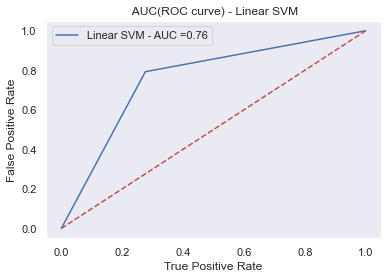

In [44]:
plot_roc_curve(y_test, bin_svm_pred, 'Linear SVM')

## Logistic Regression

In [45]:
# param_grid = {'C': [1, 10, 100], 'penalty': ["l1", "l2"],
#               "solver": ["sag", "saga"]}

# grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
# grid_lr.fit(X_train_tf_bin, y_train)

# print('Best Criterion:', grid_lr.best_params_)

In [46]:
bin_lr_clf = LogisticRegression(C = 10, penalty= 'l2',
                                solver = 'sag').fit(X_train_tf_bin, y_train) 

bin_lr_pred = bin_lr_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_lr_pred))

bin_lr_scores = cross_val_score(bin_lr_clf, X_train_tf_bin, y_train, cv=5)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_lr_scores.mean(), bin_lr_scores.std()))

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70     12585
           1       0.82      0.79      0.81     20294

    accuracy                           0.77     32879
   macro avg       0.75      0.76      0.76     32879
weighted avg       0.77      0.77      0.77     32879


 
0.78 accuracy with a standard deviation of 0.01


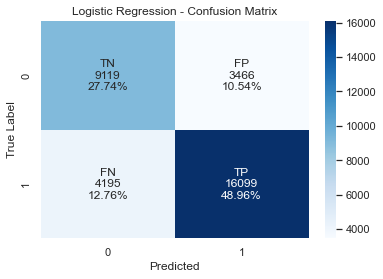

In [47]:
bin_lr_cm = confusion_matrix(y_test, bin_lr_pred)
make_confusion_matrix(bin_lr_cm, 'Logistic Regression - Confusion Matrix')

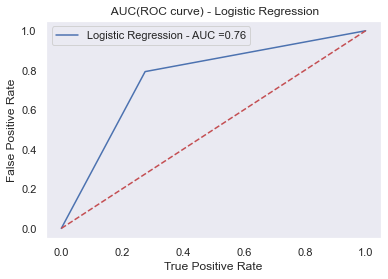

In [48]:
plot_roc_curve(y_test, bin_lr_pred, 'Logistic Regression')

## Decision Tree

In [49]:
# #Hyperparameter tuning
# param_grid_dt = {'criterion':['gini','entropy'], 'max_depth': np.arange(10, 40)}

# grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, cv=5)
# grid_dt.fit(X_train_tf_bin, y_train)

# print('Best Criterion:', grid_dt.best_params_)

In [50]:
bin_dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth=500).fit(X_train_tf_bin, y_train)
bin_dt_pred = bin_dt_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_dt_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61     12585
           1       0.75      0.78      0.77     20294

    accuracy                           0.71     32879
   macro avg       0.69      0.68      0.69     32879
weighted avg       0.70      0.71      0.71     32879



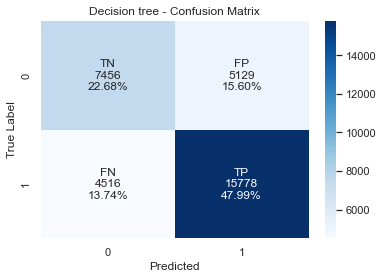

In [51]:
bin_dt_cm = confusion_matrix(y_test, bin_dt_pred)
make_confusion_matrix(bin_dt_cm, 'Decision tree - Confusion Matrix')

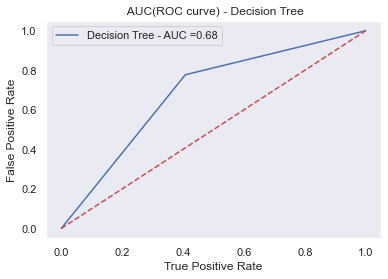

In [52]:
plot_roc_curve(y_test, bin_dt_pred, 'Decision Tree')

In [53]:
bin_dt_scores = cross_val_score(bin_dt_clf, X_train_tf_bin, y_train, cv=5)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_dt_scores.mean(), bin_dt_scores.std()))


 
0.73 accuracy with a standard deviation of 0.03


## Random Forest Classifier

In [54]:
bin_rf_clf = RandomForestClassifier(criterion = 'gini', max_depth = 500).fit(X_train_tf_bin, y_train)
bin_rf_pred = bin_rf_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_rf_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     12585
           1       0.80      0.79      0.79     20294

    accuracy                           0.75     32879
   macro avg       0.73      0.73      0.73     32879
weighted avg       0.75      0.75      0.75     32879



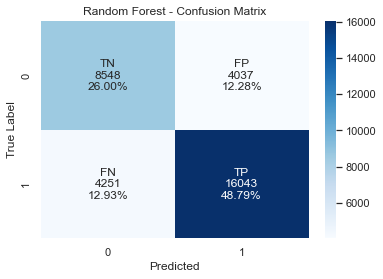

In [55]:
bin_rf_cm = confusion_matrix(y_test, bin_rf_pred)
make_confusion_matrix(bin_rf_cm, 'Random Forest - Confusion Matrix')

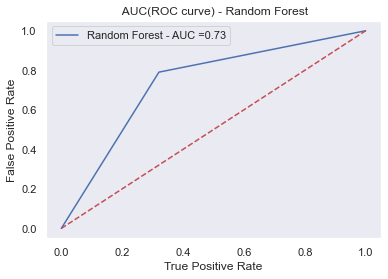

In [56]:
plot_roc_curve(y_test, bin_rf_pred, 'Random Forest')

In [57]:
bin_rf_scores = cross_val_score(bin_rf_clf, X_train_tf_bin, y_train, cv=5)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_rf_scores.mean(), bin_rf_scores.std()))

KeyboardInterrupt: 

## Calibration probabilities

In [58]:
from sklearn.calibration import CalibrationDisplay

In [59]:
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [60]:
# Create classifiers
lr = LogisticRegression(penalty='l2', solver = 'sag', C=0.5)
gnb = MultinomialNB()
svc = NaivelyCalibratedLinearSVC(C=0.5)
rfc = RandomForestClassifier(min_samples_leaf=20, min_samples_split=30)

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

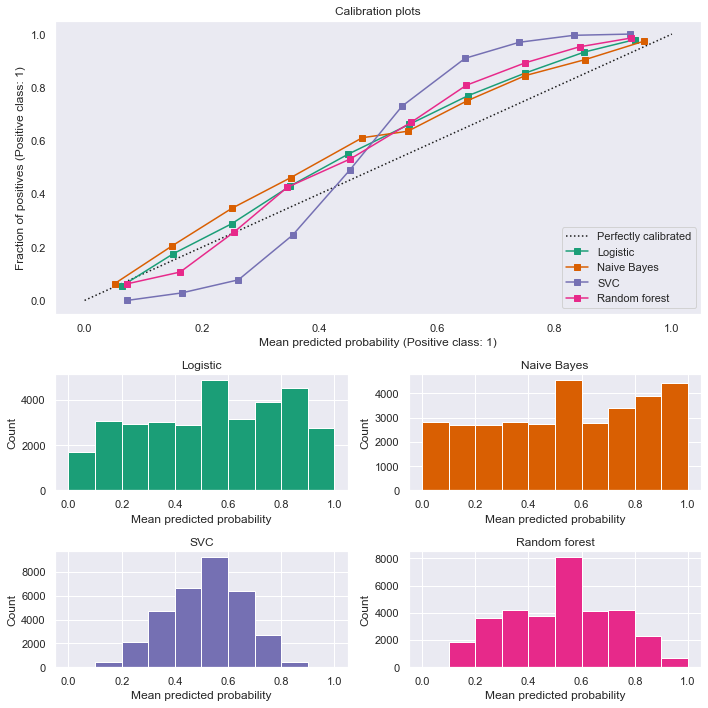

In [61]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_tf_bin, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_tf_bin,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Predict all the dataset  with NAIVE-BAYES

In [62]:
df = pd.read_csv('../../data_collection/data/dataset_all.csv')

In [63]:
X_class = df['Tweet']

In [64]:
#tokenization
X_class_tok =vect.transform(X_class)

In [65]:
#feature selection
X_class_sel_bin = bin_sel.transform(X_class_tok)

In [66]:
#weigthing
X_class_tf_bin = tf_transformer_bin.transform(X_class_sel_bin)

In [67]:
bin_lr_pred_all = bin_lr_clf.predict(X_class_tf_bin)

In [68]:
bin_lr_pred_all

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [69]:
df['tweet_label'] = bin_lr_pred_all

In [70]:
df

,User,verified,Date_Created,Follows_Count,Friends_Count,Retweet_Count,Language,Number_of_Likes,Source_of_Tweet,Tweet_Id,...,Month,Year,Year_Month,tweet_label,mention,ukr,imm,prof,migr,prof_v
0,nitewriter3,False,2022-07-14 23:47:29+00:00,2,20,0,it,0,Twitter for Android,1571699213720846337,...,9,2022,2022-9,1,"GiorgiaMeloni,FratellidItalia",0,0,0,1,0
1,Christi09341475,False,2021-12-24 13:52:34+00:00,6,31,0,it,1,Twitter for iPhone,1571145153695588353,...,9,2022,2022-9,1,"GiorgiaMeloni,FratellidItalia",0,0,0,0,0
2,Blank40195976,False,2016-06-04 22:27:20+00:00,6,29,0,it,0,Twitter for Android,1570683600823287808,...,9,2022,2022-9,0,"ragge002,eleloverre,matteosalvinimi",0,1,0,0,0
3,Blank40195976,False,2016-06-04 22:27:20+00:00,6,29,0,it,0,Twitter for Android,1570683119333961729,...,9,2022,2022-9,1,"ragge002,eleloverre,matteosalvinimi",0,0,0,0,0
4,ragge002,False,2022-05-12 09:59:04+00:00,1,45,0,it,0,Twitter for Android,1570697404068036609,...,9,2022,2022-9,0,"Blank40195976,eleloverre,matteosalvinimi",0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131872,elio_vito,True,2013-06-30 07:47:38+00:00,35678,13,422,it,3576,Twitter for iPhone,1555897515857281024,...,8,2022,2022-8,0,NaN,0,0,0,0,0
131873,matteosalvinimi,True,2011-03-23 10:32:56+00:00,1495095,2007,101,it,567,Twitter Web App,1554787555438206977,...,8,2022,2022-8,0,NaN,0,0,0,0,0
131874,FratellidItalia,True,2012-12-20 20:34:19+00:00,186737,422,198,it,809,Twitter for iPhone,1559449339726110721,...,8,2022,2022-8,0,NaN,0,0,0,0,0
131875,Agenzia_Ansa,True,2010-06-01 17:19:41+00:00,1857293,266,12,it,42,Hootsuite Inc.,1557610324655841282,...,8,2022,2022-8,1,NaN,0,0,0,0,0


C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


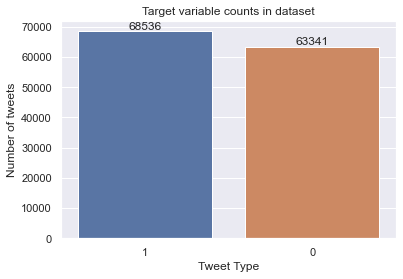

In [71]:
#controlla distribuzione
import seaborn as sns

unique= df["tweet_label"].unique()
freq = df["tweet_label"].value_counts()
sns.set(font_scale = 1)

ax = sns.countplot(df["tweet_label"], 
                   order = df["tweet_label"].value_counts().index)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

# adding the text labels
rects = ax.patches
for rect, label in zip(rects, freq):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [72]:
df.to_csv("../../data_collection/data/dataset_classified.csv")